## Golf Shot Analysis



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplcursors as mplc

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
import statsmodels.formula.api as smf

import glob
import os

In [2]:
def read_all_files(folder_path, file_extension='csv'):

    all_files = glob.glob(os.path.join(folder_path, f"*.{file_extension}"))
    if not all_files:
        return pd.DataFrame()

    all_df = []
    for f in all_files:
        df = pd.read_csv(f)
        all_df.append(df)

    combined_df = pd.concat(all_df, ignore_index=True)
    return combined_df

In [3]:
folder_path = 'shot_csvs'
file_extension = 'csv'

df = read_all_files(folder_path, file_extension)
df.head()

,Date,Club Type,Club Description,Altitude,Club Speed,Ball Speed,Carry Distance,Total Distance,Roll Distance,Smash,...,Spin Rate,Spin Axis,Spin Reading,Low Point,Club Path,Face Path,Face Target,Swing Plane Tilt,Swing Plane Rotation,Shot Classification
0,NaN,NaN,NaN,[ft],[mph],[mph],[yd],[yd],[yd],NaN,...,[rpm],[deg],NaN,[in],[deg],[deg],[deg],[deg],[deg],NaN
1,2025-03-08 10:54:25,7 Iron,NaN,5600.00,77.85,93.95,140.69,157.56,16.86,1.21,...,4681,-11.50,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull Draw
2,2025-03-08 10:54:42,7 Iron,NaN,5600.00,78.29,101.56,155.21,170.88,15.67,1.30,...,5408,-6.80,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Draw
3,2025-03-08 10:55:21,7 Iron,NaN,5600.00,77.17,98.43,147.46,162.62,15.16,1.28,...,5842,2.60,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Straight
4,2025-03-08 10:55:43,7 Iron,NaN,5600.00,78.29,99.77,150.34,166.09,15.76,1.27,...,5783,-4.50,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    120 non-null    object 
 1   Club Type               120 non-null    object 
 2   Club Description        0 non-null      float64
 3   Altitude                121 non-null    object 
 4   Club Speed              121 non-null    object 
 5   Ball Speed              121 non-null    object 
 6   Carry Distance          121 non-null    object 
 7   Total Distance          121 non-null    object 
 8   Roll Distance           121 non-null    object 
 9   Smash                   120 non-null    float64
 10  Vertical Launch         121 non-null    object 
 11  Peak Height             121 non-null    object 
 12  Descent Angle           121 non-null    object 
 13  Horizontal Launch       121 non-null    object 
 14  Carry Lateral Distance  121 non-null    ob

In [5]:
df = df.drop(['Club Description', 'Attack Angle','Dynamic Loft', 'Attack Angle', 'Dynamic Loft', 
         'Spin Loft', 'Low Point' , 'Club Path', 'Face Path', 'Face Target' , 
         'Swing Plane Tilt', 'Swing Plane Rotation'], axis=1)
df.dropna(inplace=True)

df['Club Type'] = df['Club Type'].replace('Pitching Wedge', 'PW')


In [6]:
df['Club Color'] = 0.0

def assign_color(idx, row):
    if row['Club Type'] == '9 Iron':
        df.loc[idx, 'Club Color']  = 2.0
    elif row['Club Type'] == '8 Iron':
        df.loc[idx, 'Club Color'] = 3.0
    elif row['Club Type'] == '7 Iron':
        df.loc[idx, 'Club Color'] = 4.0
    elif row['Club Type'] == '6 Iron':
        df.loc[idx, 'Club Color'] = 5.0
    elif row['Club Type'] == '5 Iron':
        df.loc[idx, 'Club Color'] = 6.0
    elif row['Club Type'] == '4 Iron':
        df.loc[idx, 'Club Color'] = 7.0
    elif row['Club Type'] == '3 Iron':
        df.loc[idx, 'Club Color'] = 8.0
    elif row['Club Type'] == 'PW':
        df.loc[idx, 'Club Color'] = 1.0

for index, row in df.iterrows():
    assign_color(index, row)


In [7]:
df['Ball Speed'] = pd.to_numeric(df['Ball Speed'])
df['Carry Distance'] = pd.to_numeric(df['Carry Distance'])
df['Total Distance'] = pd.to_numeric(df['Total Distance'])
df['Carry Lateral Distance'] = pd.to_numeric(df['Carry Lateral Distance'])
df['Carry Curve Distance'] = pd.to_numeric(df['Carry Curve Distance'])
df['Peak Height'] = pd.to_numeric(df['Peak Height'])
df['Smash'] = pd.to_numeric(df['Smash'])

df['Club Type'].unique()


array(['7 Iron', '5 Iron', '9 Iron', '8 Iron', '6 Iron', '4 Iron', 'PW',
       '3 Iron'], dtype=object)

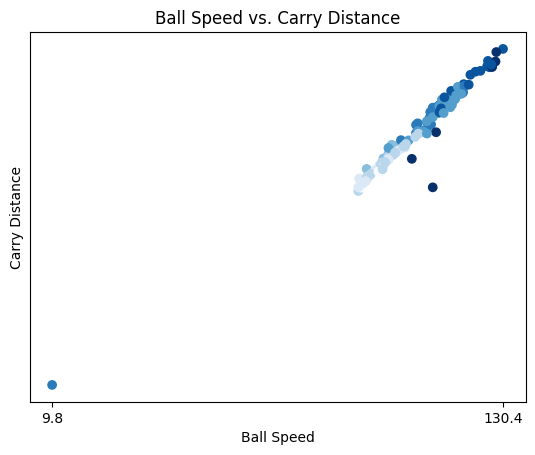

In [8]:
xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')
#plt.legend(df['Club Type'], df['Club Color'])

max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()

plt.xticks([max_speed, min_speed])
plt.yticks([])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance')
plt.show()

Removing the one horrilble shank that had a ball speed of 9.8 mph

In [9]:
min_index = df['Carry Distance'].idxmin()
df = df.drop(min_index)

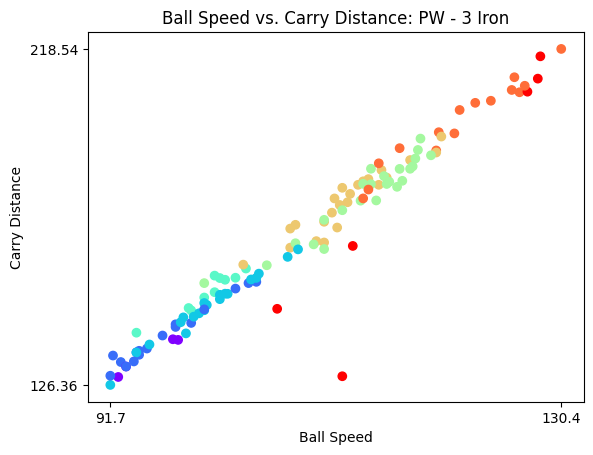

In [10]:
max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()
min_dist = df['Carry Distance'].min()

xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='rainbow', label='Club Type')

plt.xticks([max_speed, min_speed])
plt.yticks([min_dist, max_dist])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance: PW - 3 Iron')
plt.show()

Looks much better, now I will remove the 3 red outliers. My 3 iron broke during the data collection and these were the 2 shots prior to the club breaking and the 1 shot that the club head flew off of the shaft.

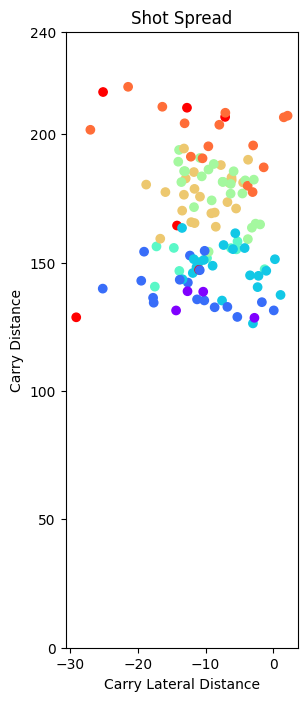

In [11]:
ypoints = df['Carry Distance']
xpoints = df['Carry Lateral Distance']


plt.figure(figsize=(3, 8))
plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='rainbow', label='Club Type')

#plt.xticks([max_speed, min_speed])
plt.yticks([0, 50, 100, 150,200,240])
plt.ylabel('Carry Distance')
plt.xlabel('Carry Lateral Distance')
plt.title('Shot Spread')
mplc.cursor(hover=True)
plt.show()

In [12]:
def getMeanDist(yardages):
    return yardages.mean()

mean_by_club = round(df.groupby('Club Type')['Carry Distance'].mean(), 2)
#mean_by_club.replace('Pitching Wedge', 'PW', inplace=True)
mean_by_club
mean_by_club = mean_by_club.rename({'Pitching Wedge': 'PW'}) 


In [13]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', bbox = dict(facecolor = 'skyblue', alpha =.7, mouseover=True))

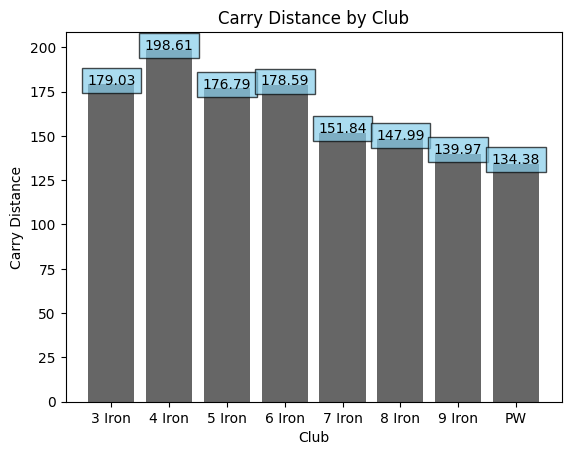

In [14]:
colors = plt.cm.Accent(df['Club Color'])
plt.bar(mean_by_club.index, mean_by_club.values, color=colors)
addlabels(mean_by_club.index, mean_by_club.values)
plt.ylabel('Carry Distance')
plt.xlabel('Club')
plt.title('Carry Distance by Club')
mplc.cursor(hover=True)
plt.show()


In [15]:
approach_data = {
    "shots": [25, 256,277,123],
    "greens hit": [8, 129, 178, 46],
    "inside 10": [2, 16,11,4],
    "distance": ["0-99", "100-149", "150-199", "200+"]
}

approach_df = pd.DataFrame(approach_data)

approach_df.head()


,shots,greens hit,inside 10,distance
0,25,8,2,0-99
1,256,129,16,100-149
2,277,178,11,150-199
3,123,46,4,200+


In [16]:
approach_df['green hit percent'] = round(approach_df['greens hit'] / approach_df['shots'], 2)
approach_df['inside 10 percent'] = round(approach_df['inside 10'] / approach_df['shots'], 2)

approach_df.head()

,shots,greens hit,inside 10,distance,green hit percent,inside 10 percent
0,25,8,2,0-99,0.32,0.08
1,256,129,16,100-149,0.50,0.06
2,277,178,11,150-199,0.64,0.04
3,123,46,4,200+,0.37,0.03


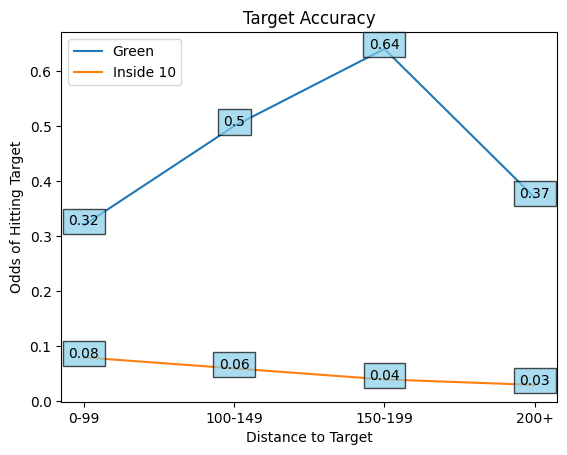

In [17]:
plt.plot(approach_df['distance'], approach_df['green hit percent'])
plt.plot(approach_df['distance'], approach_df['inside 10 percent'])
plt.xlabel('Distance to Target')
plt.ylabel('Odds of Hitting Target')
plt.title('Target Accuracy')
addlabels(approach_df['distance'], approach_df['green hit percent'])
addlabels(approach_df['distance'], approach_df['inside 10 percent'])
plt.legend(["Green", "Inside 10"], loc="upper left")
plt.show()

In [18]:
q1 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.25), 2)
q2 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.5), 2)
q3 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.75), 2)
q3

Club Type
3 Iron    209.50
4 Iron    206.96
5 Iron    182.52
6 Iron    185.66
7 Iron    155.75
8 Iron    152.36
9 Iron    143.37
PW        138.76
Name: Carry Distance, dtype: float64

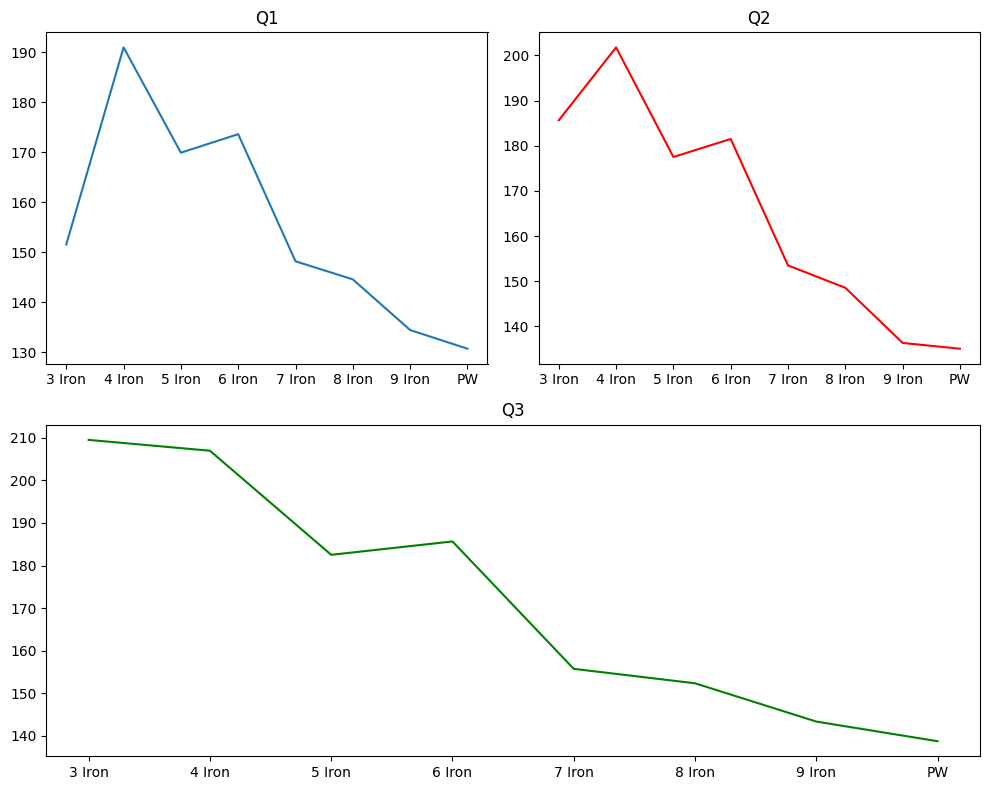

In [28]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.plot(q1.index, q1.values)
ax1.set_title('Q1')

ax2.plot(q2.index, q2.values, color='red')
ax2.set_title('Q2')

ax3.plot(q3.index, q3.values, color='green')
ax3.set_title('Q3')

plt.tight_layout()
plt.show()

In [19]:
new_df = df.drop(['Club Type', 'Date', 'Spin Reading', 'Shot Classification'],axis=1)
#new_df = new_df.drop('Club Type', axis=1)
new_df.columns


Index(['Altitude', 'Club Speed', 'Ball Speed', 'Carry Distance',
       'Total Distance', 'Roll Distance', 'Smash', 'Vertical Launch',
       'Peak Height', 'Descent Angle', 'Horizontal Launch',
       'Carry Lateral Distance', 'Total Lateral Distance',
       'Carry Curve Distance', 'Total Curve Distance', 'Spin Rate',
       'Spin Axis', 'Club Color'],
      dtype='object')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(new_df, new_df['Carry Distance'], test_size=0.2, random_state=1)

In [21]:
model = linear_model.LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [22]:
pred = model.predict(X_test)